
## Introduction

If you haven't yet see the [overview posting] for this series, please take a minute to read that first...  Are you back?  Great.  Let's dive in.  


This post is going to delve into the mechanics of _feature engineering_ for the sorts of time series data that you may use as part of a stock price prediction modeling system.  I'll cover the basic concept, then offer some useful python code "recipes" for transforming your raw source data into features which can be fed directly into a ML algorithm or ML pipeline.

## Motivation

I believe (and I don't think I'm alone) that featue engineering is the most under-appreciated part of the art of machine learning.  It's certainly the most time consuming and tedious, but it's creative and "fun" (for those who like getting their hands dirty with data, anyway...).  

Feature engineering is also one of the key areas where those with domain expertise can shine.  Those whose expertise in investing is greater than their skill in machine learning will find that feature engineering will allow them to express that expertise.  

It is particularly important to making stock predictions.  All too often, I come across an online tutorial on forecasting stock prices which simply feed in daily returns (or worse, daily prices!) into a mind-blowingly complex algorithm and conclude that machine learning does not work for price prediction. 

Feature engineering is a term of art for data science and machine learning which refers to pre-processing and transforming raw data to distill it into a form which is more easily used by machine learning algorithms.  Much like chemical processing can extract pure gold from trace elements within ore, feature engineering can extract value from very noisy data.  

Anyone who has dabbled with any systems-based trading or charting already has experience with simple forms of feature engineering, whether or not they realized it.  For instance:
* Converting a series of asset prices into percent change values is a simple form of feature engineering
* Charting prices vs. a moving average is an implicit form of feature engineering
* Any technical indicator (RSI, MACD, etc...) are also forms of feature engineering

The process takes in one or more columns of "raw" input data (e.g., OHLC price data, 10-Q financials, social media sentiment, etc...) and converts it into _many_ columns of engineered features.   


## Words of Warning

Feature engineering is fundamentally a creative process.  As such, I believe there should be a minimum of rules or limits placed on it.  However, I do believe there are a few guidelines to be followed:  

* __No peeking:__ Peeking (into the future) is the original sin of feature engineering (and prediction modeling in general).  It refers to using information about the future (or information which would not yet be known by us...) to engineer a piece of data.  This can be obvious, like using next_12_months_returns.  

 However, it's most often quite subtle, like using the mean or standard deviation across the full time period to normalize data points (which implicitly leaks future information into our features.  The test is whether you would be able to get __the exact same value__ if you were calculating the data point at that point in time rather than today. 
 

* __Only the knowable:__ A corrolary to the above, you also need to be honest about what you would have known at the time, not just what had happened at the time.  For instance, short borrowing data is reported by exchanges with a considerable time lag.  You would want to stamp the feature with the date on which you _would have known_ it.  


* __Complete the table:__ Many machine learning algorithms expect that every input feature will have a value (of a certain type) for each observation.  If you envision a spreadsheet where each feature is a column and each observation is a row, there should be a value in each cell of the table.  Quite often, some features in the table will naturally update themselves more frequently than others.  

 Price data updates almost continuously, while short inventory, analyst estimates, or EBITDA tend to update every few weeks or months.  In these cases, we'll use a scheme like last observation carried forward (LOCF) to always have a value for each feature in the naturally lower frequency columns.  Of course, we will be careful to avoid inadvertent peeking!
 

* __Avoid false ordinality:__ Finally, it's extremely important to represent features in a way that captures ordinality only if it has meaning.  For instance, it's usually a bad idea to represent "day of the week" as an integer 1 to 7 since this implicitly tells the model to treat Friday as very similar to Thursday, but "a little more".  It would also say that Sunday and Monday are totally different (if Sunday =7 and Monday =1). We could miss all manner of interesting patterns in the data.  

## Getting Started
I will begin by extracting some toy data into a dataframe using free data from [quandl](https://www.quandl.com/): 

First, we'll make a utility function which downloads one or more symbols from quandl and returns the adjusted OHLC data (I generally find adjusted data to be best).

In [6]:
import numpy as np
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like # remove once updated pandas-datareader issue is fixed
# https://github.com/pydata/pandas-datareader/issues/534
import pandas_datareader.data as web
%matplotlib inline

def get_symbols(symbols,data_source, begin_date=None,end_date=None):
    out = pd.DataFrame()
    for symbol in symbols:
        df = web.DataReader(symbol, data_source,begin_date, end_date)[['AdjOpen','AdjHigh','AdjLow','AdjClose','AdjVolume']].reset_index()
        df.columns = ['date','open','high','low','close','volume'] #my convention: always lowercase
        df['symbol'] = symbol # add a new column which contains the symbol so we can keep multiple symbols in the same dataframe
        df = df.set_index(['date','symbol'])
        out = pd.concat([out,df],axis=0) #stacks on top of previously collected data
    return out.sort_index()
        
prices = get_symbols(['AAPL','CSCO'],data_source='quandl',begin_date='2015-01-01',end_date='2017-01-01')

With the data collected, we can create a new dataframe called "features" which will be used to compile all of the features we engineer.  Good practice is to create this dataframe with an index from your downloaded data, since you should only have new feature values as you have new primary source data.  

As the simple example below illustrates, we can then construct features from the data and store into multiple feature columns.  Note that there will often be null values inserted if the formula doesn't produce valid values for each row index.    


In [4]:
features = pd.DataFrame(index=prices.index).sort_index()
features['f01'] = prices.close/prices.open-1 # daily return
features['f02'] = prices.open/prices.groupby(level='symbol').close.shift(1)-1 # gap at open 
features.tail()


f01       f02
date       symbol                    
2016-12-28 CSCO   -0.009121  0.000652
2016-12-29 AAPL    0.002404 -0.002655
           CSCO    0.002963 -0.001644
2016-12-30 AAPL   -0.007115 -0.000685
           CSCO   -0.011126  0.003283

I favor following a bland naming convention like f01, f02, etc... for each feature (and then documenting what each feature represents...) rather than using descriptive column names.  My reasons for this are three-fold: (1) descriptive names tend to be long and cumbersome to use, (2) they're rarely truely self-describing, and (3) it's often useful to create an abstraction to conceal from the modeler (either yourself or someone else) what each represents.  Think of it like a blind taste test.

Following this basic code pattern, we can generate infinite flavors of features.  This is where your domain expertise and analytical creativity come into play!  My suggestion is to make sure you have a reasonable hypothesis before you create any feature, but don't be afraid to try many variations on a theme.  There is much to be learned from trying several flavors of feature transformations out.  


## Common Transforms
In the interest of accelerating your creativity, I've listed below a series of "recipes" for some of the transforms I've found useful - especially when using linear or quasi-linear models - extract meaningful relationships.   



### Logs
Many times, values like market cap, volume, revenue can map better to the prediction target if put into log space.  This is easy to do via pandas+numpy:

In [7]:
features['f03'] = prices.volume.apply(np.log) # log of daily volume

### Differencing
It's often more important to know how a value is changing than to know the value itself.  The `diff()` method will calculate the change in value since the prior period (i.e., current minus prior).  NOTE: the "groupby" is critically important since if it were omitted we would be comparing the difference in volume between symbols, which is not what we want.  

In [8]:
features['f03'] = prices.groupby(level='symbol').volume.diff() # change since prior day
features['f04'] = prices.groupby(level='symbol').volume.diff(50) # change since 50 days prior

### Rate of Change
Even more common is to want the rate of change as expressed by percent change.  Pandas has the handy `pct_change()` method for this purpose, but beware that you'll get [odd behavior](https://stackoverflow.com/questions/50915213/using-pct-change-with-multiindex-groupby) if you mix this with `groupby()` as shown above.  I prefer to create my own lambda wrapper function as shown below.

In [10]:
pct_chg_fxn = lambda x: x.pct_change()
features['f05'] = prices.groupby(level='symbol').volume.apply(pct_chg_fxn) # change since prior day

### Moving Averages
Sometimes, we'd rather use the moving average of a value as part of a feature.  This can be the value itself if you want to minimize how "jittery" a value is.  Or, more commonly, you may want to compare a value with a trailing moving average of itself.  

Again, we need to use groupby since our dataframe has info on multiple symbols - and again, we need to use a lambda function wrapper to avoid error.  There are other patterns which will accomplish the same thing but I find this to be cleanest.     

  

In [12]:
# log of 5 day moving average of volume
ma_5 = lambda x: x.rolling(5).mean()
features['f06'] = prices.volume.groupby(level='symbol').apply(ma_5).apply(np.log) 

# daily volume vs. 200 day moving average
ma_200 = lambda x: x.rolling(200).mean()
features['f07'] = prices.volume/ prices.volume.groupby(level='symbol').apply(ma_200)-1

# daily closing price vs. 50 day exponential moving avg
ema_50 = lambda x: x.ewm(span=50).mean()
features['f08'] = prices.close/ prices.close.groupby(level='symbol').apply(ema_50)-1

SIDE NOTE: Since the rolling window is an important - and somewhat arbitrary - value, you should try a range of reasonable values.  I have found that it's better to use an exponentially increasing range of values rather than a linear range.  In other words, use [5,10,20,40,80,160] rather than [10,20,30,40...,100].  

The rationale is that values like 90 and 100 are really quite similar whereas 10 and 20 are quite different.  Therefore, if you choose linearly spaced values, you'll effectively be giving the higher end of the value range more chances to succeed than the lower values - and you'll increase the likelihood of overfitting a high value.  

### Z-Scores
A very popular/useful transformation for financial time series data is the [z-score](http://stattrek.com/statistics/dictionary.aspx?definition=z-score).  We can easily define a generalized lambda function for this, which we can use whenever needed.  Importantly, it allows us to mix together very different symbols (some high-beta, some low-beta) in a way that considers the statistical significance of any movement.  


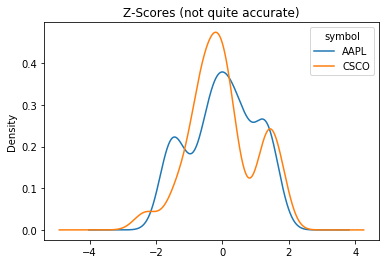

In [13]:
zscore_fxn = lambda x: (x - x.mean()) / x.std()
features['f09'] =prices.groupby(level='symbol').close.apply(zscore_fxn)
features.f09.unstack().plot.kde(title='Z-Scores (not quite accurate)')

However, the above example has a subtle but important bug.  It uses the mean _of the whole time frame_ and the standard deviation _of the whole time frame_ to calculate each datapoint.  This means we are peeking ahead into the future and the feature is potentially very danger-prone (it'll work famously well in sample and fail to work out of sample...).

Fixing this is cumbersome, but necessary.  

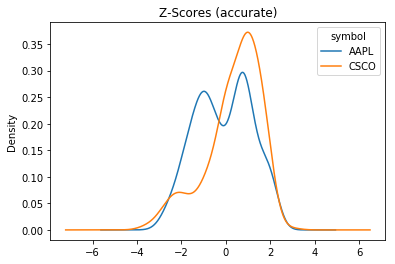

In [16]:
zscore_fun_improved = lambda x: (x - x.rolling(window=200, min_periods=20).mean())/ x.rolling(window=200, min_periods=20).std()
features['f10'] =prices.groupby(level='symbol').close.apply(zscore_fun_improved)
features.f10.unstack().plot.kde(title='Z-Scores (accurate)')

### Percentile
Less commonly used - but equally useful - is the percentile transformation.  Getting this done properly in pandas (with groupby and rolling) is possible but tricky.  The below example returns the percentile rank (from 0.00 to 1.00) of traded volume for each value as compared to a trailing 200 day period.  

Note that we need to use _a lambda within a lambda_ to make this work properly.  We're on the bleeding edge.


In [17]:
rollrank_fxn = lambda x: x.rolling(200,min_periods=20).apply(lambda x: pd.Series(x).rank(pct=True)[0],raw=True)
features['f11'] = prices.groupby(level='symbol').volume.apply(rollrank_fxn)

Another interesting application of this same pattern is to rank each stock _cross-sectionally_ rather than _longitudinally_ as above.  In other words, where does this stock rank within all of the stocks on that day, not for all prior days of that stock.  The below example isn't very meaningful with only two stocks, but quite useful when using a realistic universe.  In this example, we're also making use of an earlier feature (relative volume) to compare which symbol is most heavily traded _for that stock's normal range_ in a given day.  Also note that we need to `dropna()` prior to ranking because `rank` doesn't handle nulls very gracefully.   

In [19]:
features['f12'] = features['f07'].dropna().groupby(level='date').rank(pct=True) 

### Technical Indicators
Those with a taste for technical analysis may find it difficult to let go of your favored TA techniques.  While this is not _my_ favored approach, you'll have no problem engineering features using these methods.  From my cursory googling, it looked as though `ta` would be a good place to start.  Very new and only one contributor but it looks fairly complete and well documented.  If you find that it's missing your favorite indicators, consider contributing to the package.  If you know of better such packages, please post in the comments below...  

You may consider mean-centering a technical indicator so that machine learning methods can make better use of the data (or make sure to include that in the pre-processing pipeline when you start modeling).  


In [27]:
import ta # technical analysis library: https://technical-analysis-library-in-python.readthedocs.io/en/latest/
# money flow index (14 day)
features['f13'] = ta.momentum.money_flow_index(prices.high, prices.low, prices.close, prices.volume, n=14, fillna=False)
# mean-centered money flow index
features['f14'] = features['f13'] - features['f13'].rolling(200,min_periods=20).mean()

## Alternative Representations
A bit different than transforms are "representations", i.e., other ways to represent continuous values.  All of the transforms above returned continuous values rather than "labels", and that's often a good place to start - especally for early prototypes.

However, you may want to represent the data in different ways, especially if using classification-based approaches or worried about the [curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality) due to large numbers of features.  

### Binning
We can easily convert a continous variable to discrete "bins" (like 1 to 10).  This loses information, of course, but sometimes loss of information is a good thing if you are removing more noise than signal.  

The below example shows volumes converted into ten equally sized buckets.  In other words, we've converted a continuous variable into a discrete one.  

NOTE: this example is not applied in a rolling fashion, so it __does suffer from some data peeking__, a cardinal sin.  At the moment, I'm failing in my efforts to implement it in a rolling way.  I'd be grateful for code snippets if anyone knows how to do this offhand.   

In [21]:
n_bins = 10
bin_fxn = lambda y: pd.qcut(y,q=n_bins,labels = range(1,n_bins+1))
features['f15'] = prices.volume.groupby(level='symbol').apply(bin_fxn)

### Signing
Very simply, you may wish to convert continuous variables into positive or negative (1 or -1) values, depending on input.  For instance, was volume increasing or decreasing today?  


In [22]:
features['f16'] = features['f05'].apply(np.sign)

### Plus-Minus
You may be interested in how many days in a row a value has increased (or decreased).  Below is a simple pattern to do just that - it calculates the number of up-days minus the number of down days.  


In [23]:
plus_minus_fxn = lambda x: x.rolling(20).sum()
features['f17'] = features['f16'].groupby(level='symbol').apply(plus_minus_fxn)

### One-Hot Encoding
Possibly the most common alternative representation is "one-hot encoding" where a categorical variable is represented as a binary.  For instance, month_of_year would be represented as twelve different columns, each of which was either 0 or 1.  January would be [1,0,0,0,...0] etc...  

This is absolutely crucial in a few circumstances.  The first is where there is false meaning in the "ordinality" of values.  If we were looking to test the "santa claus effect" hypothesis, it wouldn't be helpful to use a month_of_year feature where January was "the least" and December was "the most".  

The second is in cases where we are representing events or "states".  Does the word "lawsuit" appear within the 10-Q footnotes?  Is the company in the blackout period for share buybacks?  

Finally, the particular machine learning algorithm (tree-based, neural networks) may find it easier to use binary representations than continuous or discrete ones.  

The below example creates twelve one-hot features, one for each month, and names them automatically 

In [31]:
month_of_year = prices.index.get_level_values(level='date').month
one_hot_frame = pd.DataFrame(pd.get_dummies(month_of_year))
one_hot_frame.index = prices.index # Careful!  This is forcing index values without usual pandas alignments!

# create column names 
begin_num = int(features.columns[-1][-2:]) + 1 #first available feature
feat_names = ['f'+str(num) for num in list(range(begin_num,begin_num+12,1))]

# rename columns and merge
one_hot_frame.columns = feat_names
features = features.join(one_hot_frame)
features.iloc[:,-12:].tail()

f39  f40  f41  f42  f43  f44  f45  f46  f47  f48  f49  f50
date       symbol                                                            
2016-12-28 CSCO      0    0    0    0    0    0    0    0    0    0    0    1
2016-12-29 AAPL      0    0    0    0    0    0    0    0    0    0    0    1
           CSCO      0    0    0    0    0    0    0    0    0    0    0    1
2016-12-30 AAPL      0    0    0    0    0    0    0    0    0    0    0    1
           CSCO      0    0    0    0    0    0    0    0    0    0    0    1

volume_change_ratio  momentum_5_day  intraday_chg  \
date       symbol                                                      
2015-01-06 CSCO               0.605454       -0.762693     -0.003132   
2015-01-07 AAPL              -0.390461        3.068826      0.005131   
           CSCO              -0.417079       -0.753558      0.005895   
2015-01-08 AAPL               0.480194        3.311037      0.024352   
           CSCO               0.483707       -0.751685     -0.001089   
2015-01-09 AAPL              -0.101903        3.317256     -0.005858   
           CSCO              -0.186482       -0.752627      0.004337   
2015-01-12 AAPL              -0.068729        3.172315     -0.029751   
           CSCO               0.161360       -0.759551      0.001786   
2015-01-13 AAPL               0.351276        3.177227     -0.010859   
           CSCO              -0.066607       -0.759423     -0.004077   
2015-01-14 AAPL              -0.270306        3.119382      0.006970   
           CSCO              -0.182394       -0.754882      0.002874   
2015-01-15 AAPL               0.225861        2.970434     -0.028909   
           CSCO               0.000903       -0.761477     -0.024208   
2015-01-16 AAPL               0.308251        2.933273     -0.009717   
           CSCO              -0.097081       -0.758206      0.011696   
2015-01-20 AAPL              -0.364440        3.059871      0.008160   
           CSCO               0.263702       -0.747959      0.011167   
2015-01-21 AAPL              -0.026533        3.166982      0.005507   
           CSCO              -0.130198       -0.748066     -0.007664   
2015-01-22 AAPL               0.107471        3.233684      0.019409   
           CSCO               0.689322       -0.748570      0.034483   
2015-01-23 AAPL              -0.136284        3.196405      0.006055   
           CSCO              -0.559497       -0.753014     -0.005289   
2015-01-26 AAPL               0.196926        3.235568     -0.005627   
           CSCO              -0.157434       -0.761324     -0.008859   
2015-01-27 AAPL               0.718399        2.992614     -0.029176   
           CSCO               1.510086       -0.771633     -0.022529   
2015-01-28 AAPL               0.532688        3.261693     -0.019681   
...                                ...             ...           ...   
2016-12-09 AAPL               0.270956        2.974414      0.014602   
           CSCO              -0.000370       -0.735346      0.002668   
2016-12-12 AAPL              -0.233362        2.869937      0.000088   
           CSCO              -0.190721       -0.736960      0.002992   
2016-12-13 AAPL               0.658193        2.934493      0.011859   
           CSCO               0.449166       -0.737582      0.009571   
2016-12-14 AAPL              -0.221842        2.920095      0.001304   
           CSCO               0.099912       -0.737198     -0.004575   
2016-12-15 AAPL               0.367089        2.927164      0.003813   
           CSCO              -0.241034       -0.740067      0.001308   
2016-12-16 AAPL              -0.046715        2.878261     -0.004293   
           CSCO               1.193523       -0.740406     -0.003583   
2016-12-19 AAPL              -0.373648        2.917315      0.007254   
           CSCO              -0.603743       -0.740468      0.003263   
2016-12-20 AAPL              -0.228747        2.905926      0.001799   
           CSCO              -0.038689       -0.742405     -0.008758   
2016-12-21 AAPL               0.110068        2.914713      0.002226   
           CSCO              -0.170884       -0.745058     -0.008798   
2016-12-22 AAPL               0.096820        2.868727     -0.000516   
           CSCO              -0.107198       -0.745400      0.001974   
2016-12-23 AAPL              -0.453747        2.900479      0.008046   
           CSCO              -0.291298       -0.745054     -0.000327   
2016-12-27 AAPL               0.284036        2.943315     